In [1]:
import pickle
import pandas as pd
from collections import defaultdict, OrderedDict, Counter
import time
from glob import glob
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.patches as mpatches
import re
import os
import scipy
import urllib

import sys
sys.path.append("/home/yara/Documents/PseudoFind")
from PseudoFind.pangenome_cmds import *


%matplotlib inline

In [2]:
FT_LRI = pd.read_csv('/home/yara/Documents/cystic_fibrosis/data/staphylococcus/FT_LRI.csv')
directory = '/home/yara/Documents/cystic_fibrosis/data/staphylococcus/allele_matrix/'
allele_matrix = scipy.sparse.load_npz('%s/allele_matrix.npz'%directory).todense().T

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
import random

#a hold-out dataset

In [3]:
from sklearn.model_selection import StratifiedShuffleSplit
import random

labels = np.array(FT_LRI['cystic_fibrosis_status'])
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
sss.get_n_splits(allele_matrix, labels)

for train_index, test_index in sss.split(allele_matrix, labels):
    data_FS, data_holdout = allele_matrix[train_index,:], allele_matrix[test_index,:]
    labels_FS, labels_holdout = labels[train_index], labels[test_index]
    
rand = np.array([random.randint(0, 1) for _ in range(data_FS.shape[0])])
data_FS = np.vstack((data_FS.T, rand)).T


np.savez('/home/yara/Documents/cystic_fibrosis/data/staphylococcus/machine_learning/input_data.npz',
        train_index = train_index, 
        test_index = test_index,
         rand = rand
        )

print('The proportions are as follows. The percent of CF ')
print('in the full data-set is : %f%%'%(Counter(labels)[1]/float(len(labels))))
print('in the tranining data-set is : %f%%'%(Counter(labels_FS)[1]/float(len(labels_FS))))
print('in the validation data-set is : %f%%'%(Counter(labels_holdout)[1]/float(len(labels_holdout))))

The proportions are as follows. The percent of CF 
in the full data-set is : 0.334297%
in the tranining data-set is : 0.333735%
in the validation data-set is : 0.336538%


#b feature selection

In [4]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import cross_validate, cross_val_predict,  GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [5]:
models = {'LinearSVC':LinearSVC(penalty="l1", loss="squared_hinge", dual=False, max_iter = 10000, class_weight="balanced"), 
          'LogisticRegression':LogisticRegression(penalty= "l1", dual = False),
          'RandomForestClassifier':RandomForestClassifier(n_estimators = 100)
         }
all_rows = defaultdict(list)

for model_id, clf_i in models.items():
    for c in [0.5, 1, 2]:
        if model_id == 'RandomForestClassifier':
            clf = clf_i.fit(data_FS, labels_FS)
            coef_d = dict(zip(range(data_FS.shape[1]), clf.feature_importances_))
            d = {x:y for x,y in coef_d.items() if abs(y) > abs(coef_d[data_FS.shape[1] -1])}
        else:
            clf_i.C = c
            clf = clf_i.fit(data_FS, labels_FS)
            coef_d = dict(zip(range(data_FS.shape[1]), clf.coef_.tolist()[0]))
            d = {x:y for x,y in coef_d.items() if abs(y) > abs(coef_d[data_FS.shape[1] -1])}
        all_rows['%s - C=%d - random'%(model_id,c)] = d

/usr/local/lib/python3.5/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [6]:
pickle.dump(all_rows, open('/home/yara/Documents/cystic_fibrosis/data/staphylococcus/machine_learning/ML_trial_run_2.p', 'wb'))

#c train ML models

In [7]:
training_models = {
    'LogisticRegression':LogisticRegression(solver = 'lbfgs', max_iter = 10000),
    'ExtraTreesClassifier':ExtraTreesClassifier(n_estimators = 100),
    'RandomForest':RandomForestClassifier(n_estimators = 100),
    'LinearSVC':LinearSVC(penalty="l1", dual=False, max_iter = 10000),
    'LinearSVC(L-2)':LinearSVC(penalty="l2", max_iter = 10000)
}

rows = []
for training_model_id, clf in training_models.items():
    for selection_model_id, features in all_rows.items():
        selected_features = list(features.keys())
        skf = StratifiedKFold(n_splits=10)
        scores = cross_validate(clf, data_FS[:,selected_features], labels_FS, cv=skf, return_train_score = True)
        predicted = cross_val_predict(clf, data_FS[:,selected_features], labels_FS, cv=skf)
        overfitting_proxy = (np.median(scores['train_score']) - np.median(scores['test_score']))*100

        rows.append({'ML model':training_model_id, 'FS model':selection_model_id, 
                     'F-1':metrics.f1_score(labels_FS, predicted), 
                     'Accuracy':metrics.accuracy_score(labels_FS, predicted),
                    'ROC-AUC score': metrics.roc_auc_score(labels_FS, predicted), 
                    'jaccard':metrics.jaccard_similarity_score(labels_FS, predicted),
                    'MI':metrics.normalized_mutual_info_score(labels_FS, predicted),
                     'brier_score_loss':metrics.brier_score_loss(labels_FS, predicted),
                     'precision':metrics.precision_score(labels_FS, predicted),
                     'recall':metrics.recall_score(labels_FS, predicted),
                     'No. selected features':len(selected_features),
                     'Overfitting proxy':overfitting_proxy
                    })

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='a

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='a

In [8]:
scores_res = pd.DataFrame(rows)
scores_res = scores_res.sort_values(by = 'Overfitting proxy')
scores_res.to_csv('/home/yara/Documents/cystic_fibrosis/data/staphylococcus/machine_learning//ML_trial_run_2_scores_res.csv')

In [9]:
scores_res.head(3)

,Accuracy,F-1,FS model,MI,ML model,No. selected features,Overfitting proxy,ROC-AUC score,brier_score_loss,jaccard,precision,recall
22,0.993976,0.991023,LogisticRegression - C=2 - random,0.944675,LogisticRegression,217,0.0,0.994578,0.006024,0.993976,0.985714,0.99639
19,0.993976,0.991023,LinearSVC - C=2 - random,0.944675,LogisticRegression,205,0.0,0.994578,0.006024,0.993976,0.985714,0.99639
18,0.993976,0.991023,LinearSVC - C=1 - random,0.944675,LogisticRegression,207,0.0,0.994578,0.006024,0.993976,0.985714,0.99639


#d choose best ML pipeline, run bootstrap and select minimum no. features

In [9]:
clf_i = LinearSVC(penalty="l1", loss="squared_hinge", dual=False, max_iter = 10000, class_weight="balanced")

stratified_shuffle = StratifiedShuffleSplit(n_splits=1000, test_size=0.1, random_state=0)
stratified_shuffle.get_n_splits(data_FS, labels_FS)

i = 0
bootstrap_rows = {}

for train_index, test_index in stratified_shuffle.split(data_FS, labels_FS):
    print(1000-i)
    clf = clf_i.fit(data_FS[train_index,:], labels_FS[train_index])
    coef_d = dict(zip(range(data_FS.shape[1]), clf.coef_.tolist()[0]))
    d = {x:y for x,y in coef_d.items() if abs(y) > abs(coef_d[data_FS.shape[1] -1])}
    bootstrap_rows['Try_%d'%i] = d 
    i +=1 

1000
999
998
997
996
995
994


/usr/local/lib/python3.5/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


993
992
991
990
989
988
987
986
985
984
983
982
981
980
979
978
977
976
975
974
973
972
971
970
969
968
967
966
965
964
963
962
961
960
959
958
957
956
955
954
953
952
951
950
949
948
947
946
945
944
943
942
941
940
939
938
937
936
935
934
933
932
931
930
929
928
927
926
925
924
923
922
921
920
919
918
917
916
915
914
913
912
911
910
909
908
907
906
905
904
903
902
901
900
899
898
897
896
895
894


/usr/local/lib/python3.5/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


893
892
891
890
889
888
887
886
885
884
883
882
881
880
879
878
877
876
875


/usr/local/lib/python3.5/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


874
873
872
871
870
869
868
867
866
865
864
863
862
861
860
859
858
857
856
855
854
853
852
851
850
849
848
847


/usr/local/lib/python3.5/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


846
845
844
843
842
841
840
839
838
837
836
835
834
833
832
831
830
829
828
827
826
825
824
823
822
821
820
819
818
817
816
815
814


/usr/local/lib/python3.5/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


813
812
811
810
809
808
807
806


/usr/local/lib/python3.5/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


805
804
803
802
801
800
799
798
797
796
795
794
793
792
791
790
789
788
787
786
785
784
783
782
781
780
779
778


/usr/local/lib/python3.5/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


777
776
775
774
773
772
771
770
769
768
767
766


/usr/local/lib/python3.5/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


765
764
763


/usr/local/lib/python3.5/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


762
761
760
759
758
757
756
755
754
753
752
751
750
749
748
747
746
745
744
743
742
741
740
739
738
737
736
735
734
733
732


/usr/local/lib/python3.5/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


731
730
729
728
727
726
725
724
723
722
721
720
719
718
717
716
715
714
713
712
711
710
709
708
707
706
705
704
703
702
701
700
699
698
697
696
695
694
693
692
691
690
689
688
687
686
685
684
683
682
681
680
679
678
677
676
675
674
673
672
671
670
669
668
667
666
665
664
663
662
661
660
659
658


/usr/local/lib/python3.5/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


657
656
655
654
653
652
651
650
649
648
647


/usr/local/lib/python3.5/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


646
645
644
643
642
641
640
639
638
637
636
635


/usr/local/lib/python3.5/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


634
633
632
631
630
629
628
627
626
625
624
623
622
621
620
619


/usr/local/lib/python3.5/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


618
617
616
615
614
613
612
611
610
609
608
607
606
605
604
603
602
601
600
599
598
597
596
595
594
593
592
591
590
589
588
587
586
585
584
583
582
581
580
579
578
577
576
575
574
573
572
571
570
569
568
567
566
565
564
563
562
561
560
559
558
557
556
555
554
553
552
551
550
549
548
547
546
545
544
543
542
541
540
539
538
537
536
535
534
533
532
531
530
529
528
527
526
525
524
523
522
521
520
519
518
517
516
515
514
513
512
511
510
509
508
507
506
505
504
503
502
501
500
499
498
497
496
495
494
493
492


/usr/local/lib/python3.5/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


491
490
489
488
487
486
485


/usr/local/lib/python3.5/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


484
483
482
481
480
479
478
477
476
475
474
473
472
471
470
469
468
467
466
465
464
463
462
461
460
459
458
457
456
455
454
453
452
451
450
449
448
447
446
445
444
443
442
441
440
439
438
437
436
435
434
433
432
431
430
429
428
427
426
425
424
423
422
421
420
419
418
417
416
415
414
413
412
411
410
409
408
407
406
405
404
403
402
401
400
399
398
397
396
395
394
393
392
391
390
389
388
387
386
385
384
383
382
381
380
379
378
377
376
375
374
373
372
371
370
369
368
367
366
365
364
363
362
361
360
359
358


/usr/local/lib/python3.5/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


357
356
355
354
353
352
351
350
349
348
347
346
345
344
343
342
341
340
339
338
337
336
335
334
333
332
331
330
329
328
327
326
325
324
323
322
321
320
319
318
317
316
315
314
313
312
311
310
309
308
307
306
305


/usr/local/lib/python3.5/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


304
303
302
301
300
299
298
297
296
295
294
293
292
291
290
289
288
287
286
285
284
283
282
281
280
279
278
277
276
275
274
273
272
271
270
269
268
267
266
265
264
263
262
261
260
259
258
257
256
255
254
253
252
251
250
249
248
247
246
245
244
243
242
241
240
239
238
237
236
235
234
233
232
231
230
229
228
227
226
225
224
223
222
221
220
219
218
217
216
215
214
213
212
211
210
209
208
207
206
205
204
203
202
201
200
199
198
197
196
195
194
193
192
191
190
189
188
187
186
185
184
183
182
181
180
179
178
177
176
175
174
173
172
171
170
169
168
167
166
165
164
163
162
161
160
159
158
157
156
155
154
153
152
151
150
149
148
147
146
145
144
143
142
141
140
139
138
137
136
135
134
133
132
131
130
129
128
127
126
125
124
123
122
121
120
119
118
117
116
115
114
113
112
111
110


/usr/local/lib/python3.5/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


109
108
107
106
105
104
103
102
101
100
99
98
97
96
95
94


/usr/local/lib/python3.5/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


93
92


/usr/local/lib/python3.5/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


91
90
89
88
87
86
85
84
83
82
81
80
79
78
77
76
75
74
73
72
71
70
69
68
67
66
65
64
63
62
61
60
59
58
57
56
55
54
53
52
51
50
49
48
47
46
45
44
43
42
41
40
39


/usr/local/lib/python3.5/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1


In [49]:
pickle.dump(bootstrap_rows, open('/home/yara/Documents/cystic_fibrosis/data/staphylococcus/machine_learning/bootstrap_rows_SVC_trial_2.p', 'wb'))

In [14]:
import random

In [41]:
bootstrap_res = pd.DataFrame(bootstrap_rows).fillna(0)

selected = []
for i in range(5):
    bootstrap_res_i = bootstrap_res.T.iloc[random.sample([x for x in range(bootstrap_res.shape[1])], 40)].T
    selected.append(abs(bootstrap_res_i).sum(axis = 1).sort_values(ascending = False).iloc[:40].index)

In [46]:
len(set(selected[0]) & set(selected[4]))

37

In [13]:
range(bootstrap_res.shape[0])

range(0, 1388)

Text(0.5, 1.0, 'Count of times a feature is selected in an SVM')

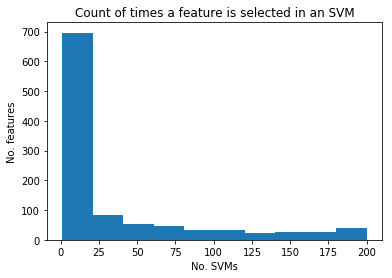

In [12]:
bootstrap_res = pd.DataFrame(bootstrap_rows).fillna(0)
bootstrap_res_i = bootstrap_res.copy()
bootstrap_res_i[bootstrap_res_i != 0] = 1
plt.hist(bootstrap_res_i.sum(axis = 1))
plt.xlabel('No. SVMs')
plt.ylabel('No. features')
plt.title('Count of times a feature is selected in an SVM')

Text(0.5, 1.0, 'Sensitivity analysis of feature set for ML training')

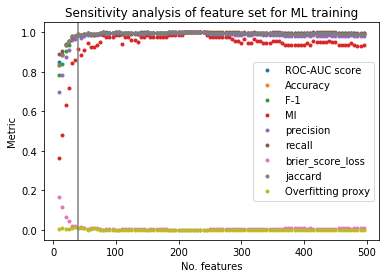

In [13]:
bootstrap_res = pd.DataFrame(bootstrap_rows).fillna(0)
sorted_features = abs(bootstrap_res).sum(axis = 1).sort_values(ascending = False)
kappa = defaultdict(dict)

skf = StratifiedKFold(n_splits=10)
clf = LinearSVC(penalty="l2", max_iter = 10000, class_weight = 'balanced')
scores_FS = []

for i in range(10,500,5):
    selected_features = sorted_features[:i].index
    scores = cross_validate(clf, data_FS[:, selected_features], labels_FS, cv=skf, return_train_score = True)
    predicted = cross_val_predict(clf, data_FS[:,selected_features], labels_FS, cv=skf)
    overfitting_proxy = (np.median(scores['train_score']) - np.median(scores['test_score']))
    
    
    scores_FS.append({
                 'F-1':metrics.f1_score(labels_FS, predicted), 
                 'Accuracy':metrics.accuracy_score(labels_FS, predicted),
#                 'Accuracy (test)':metrics.accuracy_score(labels_holdout, predicted_test),
                'ROC-AUC score': metrics.roc_auc_score(labels_FS, predicted), 
                'jaccard':metrics.jaccard_similarity_score(labels_FS, predicted),
                'MI':metrics.normalized_mutual_info_score(labels_FS, predicted, average_method='arithmetic'),
                 'brier_score_loss':metrics.brier_score_loss(labels_FS, predicted),
                 'precision':metrics.precision_score(labels_FS, predicted),
                 'recall':metrics.recall_score(labels_FS, predicted),
                 'No. selected features':len(selected_features),
                 'Overfitting proxy':overfitting_proxy
                })


scores_FS_df = pd.DataFrame(scores_FS)
for score_type in ['ROC-AUC score', 'Accuracy','F-1', 'MI', 'precision', 'recall', 'brier_score_loss', 'jaccard', 'Overfitting proxy']:
    plt.plot(scores_FS_df['No. selected features'], scores_FS_df[score_type], '.', label = score_type)
plt.legend()

t = min(scores_FS_df.loc[scores_FS_df['MI'] > 0.91]['No. selected features'])

plt.axvline(t, color = 'grey')
plt.xlabel('No. features')
plt.ylabel('Metric')
plt.title('Sensitivity analysis of feature set for ML training')

In [14]:
scores_FS_df.to_csv('/home/yara/Documents/cystic_fibrosis/data/staphylococcus/machine_learning/bootstrap_scores_SCV_trial_2.csv')
selected_features_final = sorted_features[:min(scores_FS_df.loc[scores_FS_df['MI'] > 0.91]['No. selected features'])].index
selected_features_final = pd.DataFrame(bootstrap_res.sum(axis = 1).loc[selected_features_final], columns = ['score'])
selected_features_final.to_csv('/home/yara/Documents/cystic_fibrosis/data/staphylococcus/machine_learning/selected_features_final_trial_2.csv')

In [38]:
len(selected_features_final)

40

In [24]:
# from PseudoFind.functional_annotations import *
# directory = '/home/yara/Documents/cystic_fibrosis/data/staphylococcus/functional_annotation'
# eggnog_file_sa ='%s/selected_features_final.fa.emapper.annotations'%directory
# eggnog_sa = get_eggnog(eggnog_file_sa)
# eggnog_sa

#d plot the results for the best combination

In [15]:
from sklearn.metrics import roc_curve, auc

from sklearn.metrics import confusion_matrix
import matplotlib.patches
import matplotlib.font_manager

In [1]:
import matplotlib

In [2]:
selected_features = selected_features_final.index
selected_features  = sorted_features[:240].index
clf = LinearSVC(penalty="l2", max_iter = 10000, class_weight = 'balanced')

matplotlib.rcParams.update({'font.size': 15, 'font.weight':'normal'})
fig, axes = plt.subplots(1,2, figsize = (18, 6))

lw = 2
y_score = clf.fit(data_FS[:,selected_features], labels_FS).decision_function(data_holdout[:,selected_features])
fpr, tpr, _ = roc_curve(labels_holdout, y_score)
roc_auc_multi = auc(fpr, tpr)
axes[0].plot(fpr, tpr, label='ROC curve (area = %f)'%(round(roc_auc_multi, 3)))
axes[0].plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('Receiver operating characteristic')
axes[0].legend(loc="lower right")

predicted = clf.fit(data_FS[:,selected_features], labels_FS).predict(data_holdout[:,selected_features])
conf_m = confusion_matrix(labels_holdout,predicted)

axes[1].axvline(0)
axes[1].axhline(0)
# ax=axes[1].gca()

for count,indices in enumerate([[1,1], [1,0], [0,0], [0,1]]):
    r1 = np.log(conf_m[indices[0]][indices[1]])
    c1 = matplotlib.patches.Arc((0,0), r1, r1, angle = 90, theta1 = 90*(count), theta2 = 90*(count+1))
    axes[1].add_patch(c1)

axes[1].text(-2.2, 2.2, '$\it{n}$= %d'%conf_m[1,1])
axes[1].text(1.6, 2.2, '$\it{n}$= %d'%conf_m[0,1])
axes[1].text(1.6, -2.2, '$\it{n}$= %d'%conf_m[0,0])
axes[1].text(-2.2, -2.2, '$\it{n}$= %d'%conf_m[1,0])

axes[1].axis('scaled')
axes[1].set_xticks([-1, 1])
axes[1].set_xticklabels(['Patients with \ncystic fibrosis','Patients without \n Cystic Fibrosis'])
axes[1].set_xlabel('Predicted')
axes[1].set_yticks([-1, 1])
axes[1].set_yticklabels(['Patients without \ncystic fibrosis','Patients with \n Cystic Fibrosis'])
axes[1].set_ylabel('Observed')
axes[1].set_title('Confusion matrix')

fig.suptitle('S. aureus', y = 1.1, fontsize = 30)

NameError: name 'selected_features_final' is not defined

Text(0.5, 1.0, 'Confusion matrix')

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['DejaVu Sans Display'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


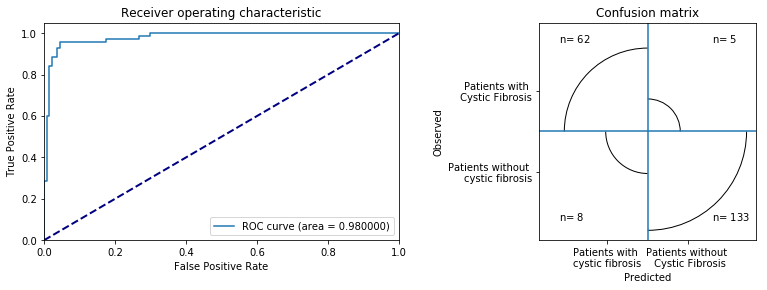

In [16]:
selected_features = selected_features_final.index
selected_features  = sorted_features[:240].index
clf = LinearSVC(penalty="l2", max_iter = 10000, class_weight = 'balanced')

matplotlib.rcParams.update({'font.size': 15, 'font.weight':'normal'})
fig, axes = plt.subplots(1,2, figsize = (18, 6))

lw = 2
y_score = clf.fit(data_FS[:,selected_features], labels_FS).decision_function(data_holdout[:,selected_features])
fpr, tpr, _ = roc_curve(labels_holdout, y_score)
roc_auc_multi = auc(fpr, tpr)
axes[0].plot(fpr, tpr, label='ROC curve (area = %f)'%(round(roc_auc_multi, 3)))
axes[0].plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('Receiver operating characteristic')
axes[0].legend(loc="lower right")

predicted = clf.fit(data_FS[:,selected_features], labels_FS).predict(data_holdout[:,selected_features])
conf_m = confusion_matrix(labels_holdout,predicted)

axes[1].axvline(0)
axes[1].axhline(0)
# ax=axes[1].gca()

for count,indices in enumerate([[1,1], [1,0], [0,0], [0,1]]):
    r1 = np.log(conf_m[indices[0]][indices[1]])
    c1 = matplotlib.patches.Arc((0,0), r1, r1, angle = 90, theta1 = 90*(count), theta2 = 90*(count+1))
    axes[1].add_patch(c1)

axes[1].text(-2.2, 2.2, '$\it{n}$= %d'%conf_m[1,1])
axes[1].text(1.6, 2.2, '$\it{n}$= %d'%conf_m[0,1])
axes[1].text(1.6, -2.2, '$\it{n}$= %d'%conf_m[0,0])
axes[1].text(-2.2, -2.2, '$\it{n}$= %d'%conf_m[1,0])

axes[1].axis('scaled')
axes[1].set_xticks([-1, 1])
axes[1].set_xticklabels(['Patients with \ncystic fibrosis','Patients without \n Cystic Fibrosis'])
axes[1].set_xlabel('Predicted')
axes[1].set_yticks([-1, 1])
axes[1].set_yticklabels(['Patients without \ncystic fibrosis','Patients with \n Cystic Fibrosis'])
axes[1].set_ylabel('Observed')
axes[1].set_title('Confusion matrix')

fig.suptitle('S. aureus', y = 1.1, fontsize = 30)

In [25]:
directory = '/home/yara/Documents/cystic_fibrosis/data/staphylococcus/allele_matrix/'
col_rows = pickle.load(open('%s/col_rows.p'%directory, 'rb'))
input_data = np.load('/home/yara/Documents/cystic_fibrosis/data/staphylococcus/machine_learning/input_data.npz')
train_index = input_data['train_index']
test_index = input_data['test_index']

In [26]:
FT_LRI = pd.read_csv('/home/yara/Documents/cystic_fibrosis/data/staphylococcus/FT_LRI.csv', dtype = {'Genome ID':str}).set_index('Genome ID')

In [28]:
FT = pd.read_csv('/home/yara/Documents/staph_clinical_isolates/data/metadata/PATRIC_FT.csv', dtype = {'Genome ID':str},low_memory=False).fillna('').replace('missing','').set_index('Genome ID')

In [36]:
holdout_gids = col_rows[0][test_index]

# predicted to be from CF patient, but actually isn;t
FT.loc[set(holdout_gids[predicted == 1]) & set(holdout_gids[labels_holdout == 0])]['Comments']

/home/yara/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  after removing the cwd from sys.path.


Genome ID
1280.16730     In this study, we performed whole-genome seque...
1280.16420                                                 SAM-2
Sakoulas_15                                                  NaN
1280.16737     In this study, we performed whole-genome seque...
1422223.3                                            MRSA USA100
Name: Comments, dtype: object

In [37]:
FT.loc[set(holdout_gids[predicted == 0]) & set(holdout_gids[labels_holdout == 1])]['Comments']

Genome ID
1280.12447    Population dynamics of S. aureus in Cystic Fib...
1280.12528    Population dynamics of S. aureus in Cystic Fib...
1280.18623    Staphylococcus aureus is often an early coloni...
1280.18617    Staphylococcus aureus is often an early coloni...
1280.4347     The genetic disorder cystic fibrosis is a life...
1280.12347    Population dynamics of S. aureus in Cystic Fib...
1280.12471    Population dynamics of S. aureus in Cystic Fib...
1280.12438    Population dynamics of S. aureus in Cystic Fib...
Name: Comments, dtype: object

In [34]:
FT.loc[holdout_gids[predicted != labels_holdout]]['Comments']

/home/yara/.local/lib/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


1280.18623     Staphylococcus aureus is often an early coloni...
1422223.3                                            MRSA USA100
1280.16420                                                 SAM-2
1280.18617     Staphylococcus aureus is often an early coloni...
1280.12438     Population dynamics of S. aureus in Cystic Fib...
1280.12447     Population dynamics of S. aureus in Cystic Fib...
1280.16730     In this study, we performed whole-genome seque...
1280.16737     In this study, we performed whole-genome seque...
1280.12347     Population dynamics of S. aureus in Cystic Fib...
Sakoulas_15                                                  NaN
1280.12528     Population dynamics of S. aureus in Cystic Fib...
1280.4347      The genetic disorder cystic fibrosis is a life...
1280.12471     Population dynamics of S. aureus in Cystic Fib...
Name: Comments, dtype: object